In [18]:
!python -V

Python 3.9.12


In [19]:
import pandas as pd

In [20]:
import pickle

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import root_mean_squared_error

In [23]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-duration-experiment")

<Experiment: artifact_location='/workspaces/mlops/02/experiment_tracking/mlruns/1', creation_time=1739268346320, experiment_id='1', last_update_time=1739268346320, lifecycle_stage='active', name='nyc-duration-experiment', tags={}>

In [24]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [25]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829623

C:\Users\rider\AppData\Local\Temp\ipykernel_14904\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\rider\AppData\Local\Temp\ipykernel_14904\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


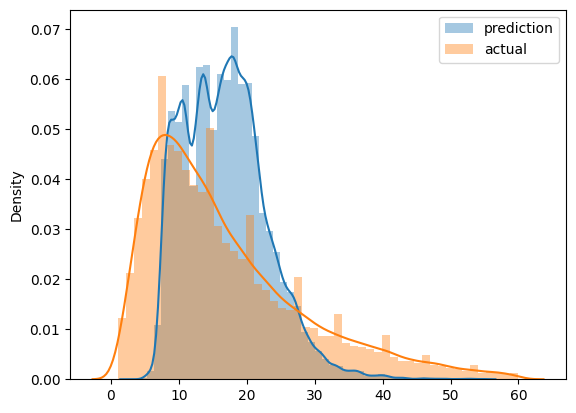

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [27]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [28]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [29]:
len(df_train), len(df_val)

(73908, 61921)

In [30]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [31]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [32]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():
    mlflow.set_tag("developer", "luca")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "/data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [34]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("developer", "luca")
        mlflow.set_tag("model", "xgboost")

        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
        )

        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
    return {"loss": rmse, "status": STATUS_OK}


search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=5, trials=Trials()
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

c:\Users\rider\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68784                          
[1]	validation-rmse:7.30748                          
[2]	validation-rmse:6.80339                          
[3]	validation-rmse:6.61505                          
[4]	validation-rmse:6.53183                          
[5]	validation-rmse:6.49234                          
[6]	validation-rmse:6.47073                          
[7]	validation-rmse:6.45680                          
[8]	validation-rmse:6.44900                          
[9]	validation-rmse:6.44183                          
[10]	validation-rmse:6.43779                         
[11]	validation-rmse:6.43345                         
[12]	validation-rmse:6.42776                         
[13]	validation-rmse:6.42330                         
[14]	validation-rmse:6.41836                         
[15]	validation-rmse:6.41492                         
[16]	validation-rmse:6.40996                         
[17]	validation-rmse:6.40660                         
[18]	validation-rmse:6.40218

c:\Users\rider\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.09048                                                  
[1]	validation-rmse:8.73026                                                   
[2]	validation-rmse:7.88765                                                   
[3]	validation-rmse:7.38343                                                   
[4]	validation-rmse:7.07970                                                   
[5]	validation-rmse:6.89761                                                   
[6]	validation-rmse:6.77760                                                   
[7]	validation-rmse:6.70525                                                   
[8]	validation-rmse:6.64955                                                   
[9]	validation-rmse:6.61704                                                   
[10]	validation-rmse:6.59456                                                  
[11]	validation-rmse:6.57944                                                  
[12]	validation-rmse:6.56676                        

c:\Users\rider\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [21:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:9.20265                                                   
[7]	validation-rmse:8.92950                                                   
[8]	validation-rmse:8.68510                                                   
[9]	validation-rmse:8.46751                                                   
[10]	validation-rmse:8.27345                                                  
[11]	validation-rmse:8.10074                                                  
[12]	validation-rmse:7.94883                                                  
[13]	validation-rmse:7.81335                                                  
[14]	validation-rmse:7.69350                                                  
[15]	validation-rmse:7.58678                                                  
[16]	validation-rmse:7.49249                                                  
[17]	validation-rmse:7.40883                                                  
[18]	validation-rmse:7.33546                        

c:\Users\rider\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00813                                                  
[1]	validation-rmse:10.04177                                                  
[2]	validation-rmse:9.27371                                                   
[3]	validation-rmse:8.66848                                                   
[4]	validation-rmse:8.19607                                                   
[5]	validation-rmse:7.82887                                                   
[6]	validation-rmse:7.54797                                                   
[7]	validation-rmse:7.33341                                                   
[8]	validation-rmse:7.16700                                                   
[9]	validation-rmse:7.03888                                                   
[10]	validation-rmse:6.94000                                                  
[11]	validation-rmse:6.86321                                                  
[12]	validation-rmse:6.80163                        

c:\Users\rider\miniconda3\envs\mlops\lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44213                                                  
[1]	validation-rmse:10.76558                                                  
[2]	validation-rmse:10.17381                                                  
[3]	validation-rmse:9.66005                                                   
[4]	validation-rmse:9.21062                                                   
[5]	validation-rmse:8.82451                                                   
[6]	validation-rmse:8.48936                                                   
[7]	validation-rmse:8.20437                                                   
[8]	validation-rmse:7.95673                                                   
[9]	validation-rmse:7.74763                                                   
[10]	validation-rmse:7.56804                                                  
[11]	validation-rmse:7.41383                                                  
[12]	validation-rmse:7.28221                        

In [3]:
logged_model = 'runs:/a16e49bf19e34de98a3fac034270f65d/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [4]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: a16e49bf19e34de98a3fac034270f65d

In [6]:
xgboost_model = mlflow.xgboost.load_model('runs:/a16e49bf19e34de98a3fac034270f65d/model')

In [7]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri='http://127.0.0.1:5000')

In [9]:
client.create_experiment(name='Test Experiment')

'2'

In [37]:
from mlflow.entities import ViewType

best_runs = client.search_runs(
    experiment_ids="1",
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=['metrics.rmse ASC']
)


In [38]:
for run in best_runs:
    print(f'Run id {run.info.run_id}, metrics: {run.data.metrics}')

Run id ba0962d33793465ea09a4fcd97d0ca0d, metrics: {'rmse': 6.31083327733179}
Run id 3e5f56338eed4efea4eea6c3ad45bd0e, metrics: {'rmse': 6.333603291846044}
Run id 5362bbec2ded4c31ba5119af6864fe57, metrics: {'rmse': 6.435780598558463}
Run id 512027edc3f145eebbcebae0632dc36e, metrics: {'rmse': 6.444869601539705}
Run id 410a5b13720c44768c366dc6fb3ba4ed, metrics: {'rmse': 6.528598405449922}


In [39]:
run_id = 'ba0962d33793465ea09a4fcd97d0ca0d'
model_uri = f'runs:/{run_id}/model'

mlflow.register_model(model_uri=model_uri, name='nyc-taxi-regressor')

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
2025/02/11 22:01:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-taxi-regressor, version 2
Created version '2' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1739286067537, current_stage='None', description='', last_updated_timestamp=1739286067537, name='nyc-taxi-regressor', run_id='ba0962d33793465ea09a4fcd97d0ca0d', run_link='', source='/workspaces/mlops/02/experiment_tracking/mlruns/1/ba0962d33793465ea09a4fcd97d0ca0d/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='2'>

In [ ]:
latest_version = client.get_latest_versions(name="nyc-taxi-regressor")

for version in latest_version:
    print(version)

<ModelVersion: aliases=[], creation_timestamp=1739286067537, current_stage='None', description='', last_updated_timestamp=1739286067537, name='nyc-taxi-regressor', run_id='ba0962d33793465ea09a4fcd97d0ca0d', run_link='', source='/workspaces/mlops/02/experiment_tracking/mlruns/1/ba0962d33793465ea09a4fcd97d0ca0d/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='2'>


C:\Users\rider\AppData\Local\Temp\ipykernel_14904\1447312600.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_version = client.get_latest_versions(name="nyc-taxi-regressor")


In [ ]:
client.transition_model_version_stage(
    name="nyc-taxi-regressor",
    version=2,
    stage="Staging",
    archive_existing_versions=False,
)